## Denoising Diffusion Probabilistic Models

In [3]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from n_framework import*
from activations_module import *

In [4]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [5]:
clean_mem()

In [6]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

- resizing our images to 32 by 32 from 28 by 28... to make it easier for model architecture

In [7]:
@inplace
def transformi(b): b[x] = [ TF.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[x]]

In [8]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

* DDPM ( Denoising Diffusion Probabilistic Models ) is a u-net with modification like adding attention

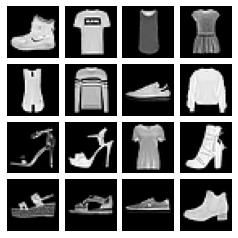

In [9]:
show_images(xb[:16], imsize=0.8)

In [10]:
betamin,betamax,n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin,betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

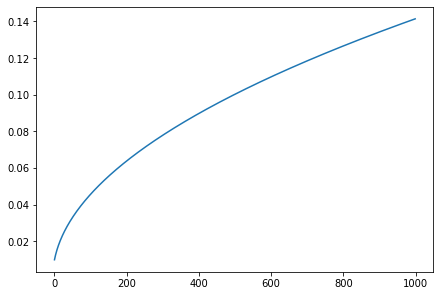

In [11]:
plt.plot(sigma)

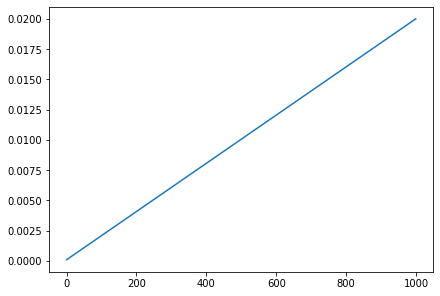

In [12]:
plt.plot(beta)

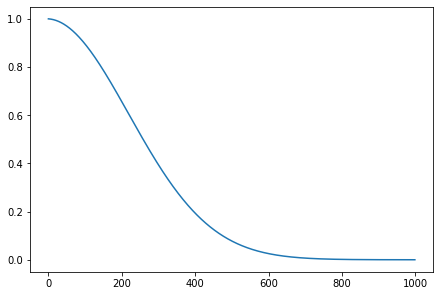

In [13]:
plt.plot(alphabar)

In [14]:
def noisify(x0,alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype= torch.long)
    epselon = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1,1,1,1).to(device)
    xt = alphabar_t.sqrt()*x0 + (1 - alphabar_t).sqrt()*epselon
    return (xt, t.to(device)),epselon

In [15]:
(xt,t),epselon = noisify(xb[:25],alphabar)
t

tensor([876, 414,  26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295, 567, 706, 749, 876,  73, 111, 899, 213, 541])

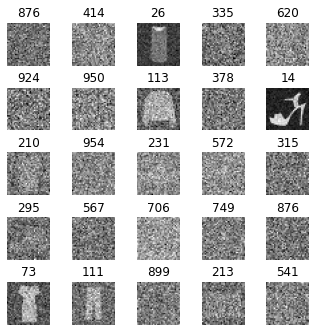

In [16]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=0.9,titles=titles)

installing diffusers will give so many errors untill hugging face recommendation of using conda installing.  
`conda install -c conda-forge diffusers`..... if you have mamba change conda for mamba(as mamba is faster version of conda)

In [1]:
from diffusers import UNet2DModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [17]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [18]:
class DDPMCB(callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, betamin, betamax): 
        fc.store_attr()
        self.beta = torch.linspace(self.betamin, self.betamax, self.n_steps)
        self.alpha = 1. - self.beta
        self.alphabar = torch.cumprod(self.alpha, dim=0)
        self.sigma = beta.sqrt()
        
    def before_batch(self,learn): learn.batch = noisify(learn.batch[0], self.alphabar)
    def sample(self, model,sz): return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.n_steps) 

In [19]:
class UNet(UNet2DModel):
    def forward(self,x): return super().forward(*x).sample

In [20]:
ddpm_cb = DDPMCB(n_steps=1000, betamin=0.0001, betamax= 0.02)

NameError: name 'beta' is not defined

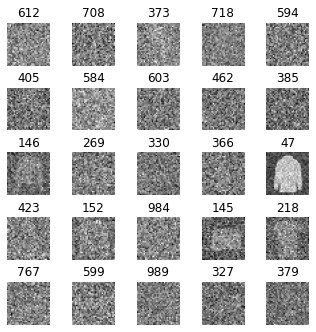

In [21]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16,32,64,64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs = [ddpm_cb, SingleBatchCB()])
(xt,t),epselon = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=0.9)

In [22]:
lr = 5e-3
epochs=5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr =lr, total_steps = tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchschedCB(sched)]

In [23]:
model = UNet(in_channels=1, out_channels=1, block_out_channels= (16, 32, 64, 128), norm_num_groups=8)

In [24]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)
                
    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()
    model.conv_out.weight.data.zero_()

In [25]:
init_ddpm(model)

In [26]:
opt_func = partial(optim.AdamW, eps = 1e-5)
learn = TrainLearner(model , dls, nn.MSELoss(), cbs=cbs, lr=lr, opt_func=opt_func)

loss,epoch,train
0.149,0,train
0.026,0,eval
0.023,1,train
0.021,1,eval
0.020,2,train
0.020,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.018,4,eval


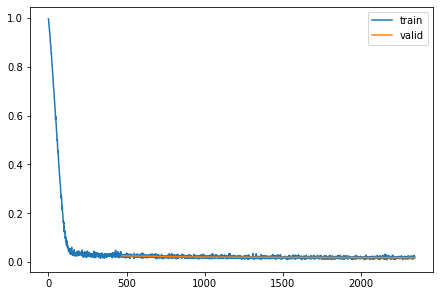

In [27]:
learn.fit(epochs)

In [ ]:
mdl_path= Path('models')

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm_jh.pkl')

##### Sampling

In [35]:
samples = ddpm_cb.sample(learn.model,(16,1,32,32))

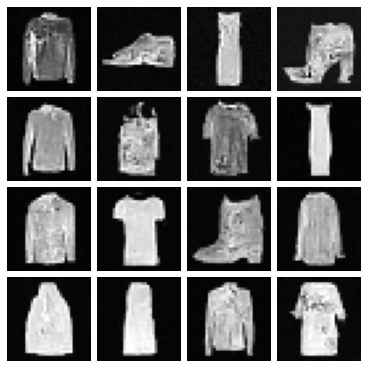

In [36]:
show_images(samples[-1],figsize=(5,5))

### Mixed precision

In [37]:
bs =512

In [38]:
next(iter(DataLoader(tds['train'],batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [40]:
def collate_ddpm(b): return noisify(default_collate(b)[x],alphabar)
def dl_ddpm(ds): return DataLoader(ds,batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [42]:
dls = DataLoaders(dl_ddpm(tds['train']),dl_ddpm(tds['test']))